In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat

import pysindy as ps

# Quasiperiodic cavity flow

This example demonstrates the use of SINDy to learn a model for the quasiperiodic dynamics in a shear-driven cavity at Re=7500, following [Callaham, Brunton, and Loiseau (2021)](https://arxiv.org/abs/2106.02409).  As in the cylinder wake example (see notebook 3), the reduced-order model appproximates the 2D time-varying velocity field $\mathbf{u}(\mathbf{x}, t)$ with the POD expansion
$$
\mathbf{u}(\mathbf{x}, t) = \sum_{j=1}^r \boldsymbol{\psi}_j(\mathbf{x}) a_j(t).
$$
The POD expansion gives us the spatial modes $\boldsymbol{\psi}_j(\mathbf{x})$ and a time series for the coefficients $a_j(t)$.  This time series serves as the training data; if we can learn an ODE model
$$
\dot{\mathbf{a}} = \mathbf{f}(\mathbf{a})
$$
for the coefficients then we can evaluate the model cheaply and reconstruct the full velocity field.

## 1. POD analysis

Since the full Direct Numerical Solution (DNS) fields and POD modes are too large to store in a standard GitHub repository, we'll just start with the set of POD coefficients $\mathbf{a}(t)$.  Since our POD modes represent velocity components, the squared amplitude of each mode $|a_j|^2$ is conveniently equivalent to the kinetic energy content of that mode and also the singular values or POD eigenvalues (see standard references on POD like [this](https://www.cambridge.org/core/books/turbulence-coherent-structures-dynamical-systems-and-symmetry/4D353229751BBB24C8C266B4714CA9F2) or [this](https://arc.aiaa.org/doi/10.2514/1.J056060)).

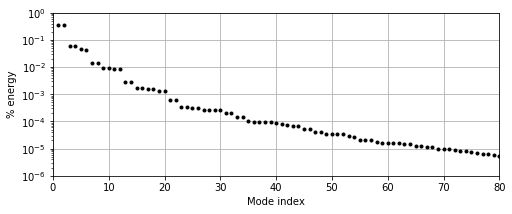

In [2]:
data = loadmat("data/cavityPOD.mat")

t_dns = data['t'].flatten()
dt_dns = t_dns[1]-t_dns[0]
a_dns = data['a']
singular_vals = data['svs'].flatten()

plt.figure(figsize=(8, 3))
plt.semilogy(1+np.arange(len(singular_vals)), singular_vals/sum(singular_vals), 'k.')
plt.grid()
plt.xlim([0, 80])
plt.ylim([1e-6, 1e0])
plt.ylabel("% energy")
plt.xlabel("Mode index")

plt.show()

Although the energy doesn't decay quite as quickly as in the cylinder example, by $r=64$ the POD modes contain $\sim 0.001 \%$ of the total fluctuating (mean-subtracted) kinetic energy.  We'll arbitrarily choose this as a truncation value for now, since it leaves a small residual and is a nice round multiple of 2.

It is also helpful to look at the power spectral density; note the approximately discrete peaks in log-energy.  These are characteristic of quasiperiodic dynamics generated by oscillations at incommensurate frequencies.

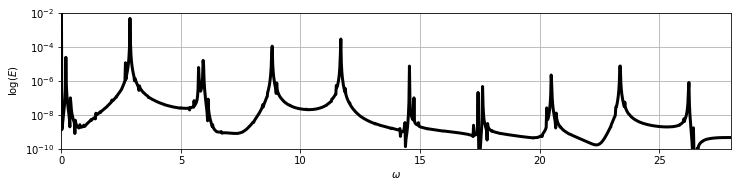

In [3]:
# Basic power spectral density estimate using FFT
def psd_est(E, dt=1):
    Ehat = np.abs((dt*np.fft.fft(E))**2)
    Ehat = Ehat[:int(len(Ehat)/2)]
    N = len(Ehat)
    freq = 2*np.pi*np.arange(N)/(2*dt*N)  # Frequencies in rad/s
    return Ehat, freq

E_dns = np.sum(a_dns**2, axis=1)
psd, freq = psd_est(E_dns, dt=dt_dns)
    
plt.figure(figsize=(12, 2.5))
plt.semilogy(freq, psd, 'k', lw=3)
plt.xlim([0, 28])
plt.ylim([1e-10, 1e-2])
plt.xlabel('$\omega$')
plt.ylabel('$\log(E)$')
plt.grid()
plt.show()


## 2. Galerkin projection

The standard approach to POD-based reduced-order modeling is to construct a physics-based model for $\mathbf{f}(\mathbf{a})$ using a technique called _Galerkin projection_ (see the paper referenced above for details).  The model is of the form
$$
\dot{\mathbf{a}} = \mathbf{C} + \mathbf{L}\mathbf{a} + \mathbf{Q}(\mathbf{a}),
$$
including terms that are constant, linear, and quadratic in $\mathbf{a}$ ($\mathbf{C}$, $\mathbf{L}$, and $\mathbf{Q}$, respectively).  In general, all of these arrays will be dense, so for a model containing $r$ modes the cost of simulating the reduced-order model scales with $\mathcal{O}(r^3)$.  This can get fairly expensive, but even worse, even if great care is taken in constructing the Galerkin system, this type of model is often inaccurate or unstable.  Our goal is to use SINDy to learn a more efficient and accurate approximation to $\mathbf{f}(\mathbf{a})$, but Galerkin is a convenient baseline

Without getting into the details of computing the Galerkin projection, we'll assume we've already computed this model.

In [4]:
class GalerkinROM():
    
    def __init__(self, file):
        model_dict = loadmat(file)
        self.C = model_dict['C'][0]
        self.L = model_dict['L']
        self.Q = model_dict['Q']
        
    def integrate(self, x0, t, r=None,
                  rtol=1e-3, atol=1e-6):
        if r is None: r=len(C)
            
        # Truncate model as indicated
        C = self.C[:r]
        L = self.L[:r, :r]
        Q = self.Q[:r, :r, :r]
            
        # RHS of POD-Galerkin model, for time integration
        rhs = lambda t, x: C + (L @ x) + np.einsum('ijk,j,k->i', Q, x, x)
        
        sol = solve_ivp(rhs, (t[0], t[-1]), x0[:r], t_eval=t, rtol=rtol, atol=atol)
        return sol.y.T

In [5]:
# Simulate Galerkin system at various truncation levels

galerkin_model = GalerkinROM('data/cavityGalerkin.mat')

dt = 1e-2
t_sim = np.arange(0, 300, dt)

a0 = a_dns[0, :]

use_constant = True
a_gal16 = galerkin_model.integrate(a0, t_sim, r=16,
               rtol=1e-8, atol=1e-8)
a_gal32 = galerkin_model.integrate(a0, t_sim, r=32,
               rtol=1e-8, atol=1e-8)
a_gal64 = galerkin_model.integrate(a0, t_sim, r=64,
               rtol=1e-8, atol=1e-8)

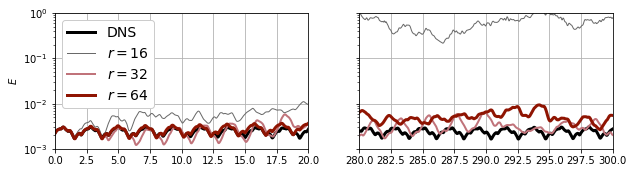

In [6]:
# Plot energy

rE = 64
E_dns = np.sum(a_dns[:, :rE]**2, 1)
E_gal16 = np.sum(a_gal16[:, :rE]**2, 1)
E_gal32 = np.sum(a_gal32[:, :rE]**2, 1)
E_gal64 = np.sum(a_gal64[:, :rE]**2, 1)

plt.figure(figsize=(10, 2.5))
plt.subplot(121)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal16, label='$r=16$', lw=1, c='dimgrey')
plt.plot(t_sim, E_gal32, label='$r=32$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal64, label='$r=64$', lw=3, c='xkcd:brick red')
plt.gca().set_yscale('log')
plt.xlim([0, 20])
plt.ylim([1e-3, 1e0])
plt.ylabel('$E$')
plt.legend(loc=0, fancybox=True, framealpha=1, fontsize=14)
plt.grid()

plt.subplot(122)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal16, label='$r=16$', lw=1, c='dimgrey')
plt.plot(t_sim, E_gal32, label='$r=32$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal64, label='$r=64$', lw=3, c='xkcd:brick red')
plt.gca().set_yscale('log')
plt.xlim([280, 300])
plt.ylim([1e-3, 1e0])
plt.gca().set_yticklabels([])
plt.grid()

plt.subplots_adjust(wspace=0.2)
plt.show()

Even though the residual energy from truncation is tiny, the Galerkin model still diverges from the true behavior of the flow.  This is still true if the truncation is extended further, but you can probably tell that even at $r=64$ the cubic scaling of the ODE system is starting to catch up with us (although it's still a lot faster than the DNS!).

In [7]:
import matplotlib.gridspec as gridspec

# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'k')
        plt.plot(t, xdot_test_pred[:, i], 'r--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'k')
        plt.plot(t, x_test_pred[:, i], 'r--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')

In [8]:
# Build the energy-preserving quadratic nonlinearity constraints (assuming a bias term)
def make_constraints_bias(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0) + 1
    p = r + r * (r - 1) + int(r * (r - 1)*(r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix


# Build the energy-preserving quadratic nonlinearity constraints (assuming a bias term)
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1)*(r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    

# Make the projection tensors used for the algorithm
def make_Ptensor(r):
    N = int((r ** 2 + 3 * r) / 2.0)

    # delta_{il}delta_{jk}
    PL_tensor = np.zeros((r, r, r, N))
    PL_tensor_unsym = np.zeros((r, r, r, N))
    for i in range(r):
        for j in range(r):
            for k in range(r):
                for l in range(N):
                    if i == l and j == k:
                        PL_tensor_unsym[i, j, k, l] = 1.0

    # Now symmetrize PL
    for i in range(r):
        for j in range(N):
            PL_tensor[:, :, i, j] = 0.5 * (PL_tensor_unsym[:, :, i, j] + PL_tensor_unsym[:, :, i, j].T)

    # if j == k, delta_{il}delta_{N-r+j,n}
    # if j != k, delta_{il}delta_{r+j+k-1,n}
    PQ_tensor = np.zeros((r, r, r, r, N))
    for i in range(r):
        for j in range(r):
            for k in range(r):
                for l in range(r):
                    for n in range(N):
                        if (j == k) and (n == N - r + j) and (i == l):
                            PQ_tensor[i, j, k, l, n] = 1.0
                        if (j != k) and (n == r + j + k - 1) and (i == l):
                            PQ_tensor[i, j, k, l, n] = 1.0 / 2.0
        
    return PL_tensor_unsym, PL_tensor, PQ_tensor

## 3. SINDy model

As a first pass at improving the reduced-order model, let's try learning a SINDy model for the POD coefficients.

In [9]:
# Load training data

dt = 0.02
r = 2
n = r + 1

data_run1 = loadmat("data/PODcoefficients.mat")
x_run1 = np.concatenate(
    (data_run1["alpha"][:5000, :r], data_run1["alphaS"][:5000, 0:1]), axis=1
)
t_run1 = np.arange(0, dt * x_run1.shape[0], dt)

data_run2 = loadmat("data/PODcoefficients_run1.mat")
x_run2 = np.concatenate(
    (data_run2["alpha"][:3000, :r], data_run2["alphaS"][:3000, 0:1]), axis=1
)
t_run2 = np.arange(0, dt * x_run2.shape[0], dt)

x_train = [x_run1, x_run2]
t_train = [t_run1, t_run2]

In [10]:
# Fit the model

optimizer = ps.STLSQ(threshold=1e-4)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, feature_names=["x", "y", "z"]
)
model.fit(x_train, t_train, multiple_trajectories=True, quiet=True)
model.print()

x' = -0.133 1 + -0.009 x + -1.023 y + -0.001 z + -0.002 y z
y' = -0.057 1 + 1.035 x + 0.005 y + 0.002 x z + -0.002 y z
z' = -20.653 1 + -0.294 z + 0.001 x^2 + 0.001 y^2 + -0.001 z^2


In [11]:
# Simulate the model

x_simulate_run1 = model.simulate(x_run1[0], np.arange(0, 100, 0.02))
x_simulate_run2 = model.simulate(x_run2[0], np.arange(0, 95, 0.02))

/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


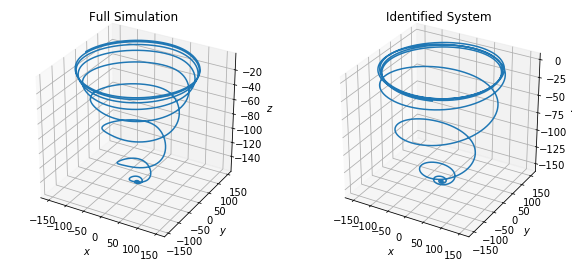

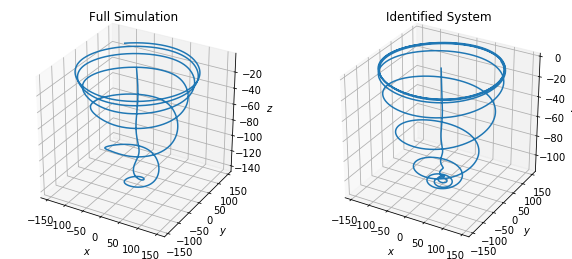

In [12]:
# Plot results

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_run1[:, 0], x_run1[:, 1], x_run1[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Full Simulation")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x_simulate_run1[:, 0], x_simulate_run1[:, 1], x_simulate_run1[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Identified System")

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_run2[:, 0], x_run2[:, 1], x_run2[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Full Simulation")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x_simulate_run2[:, 0], x_simulate_run2[:, 1], x_simulate_run2[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Identified System")
fig.show()

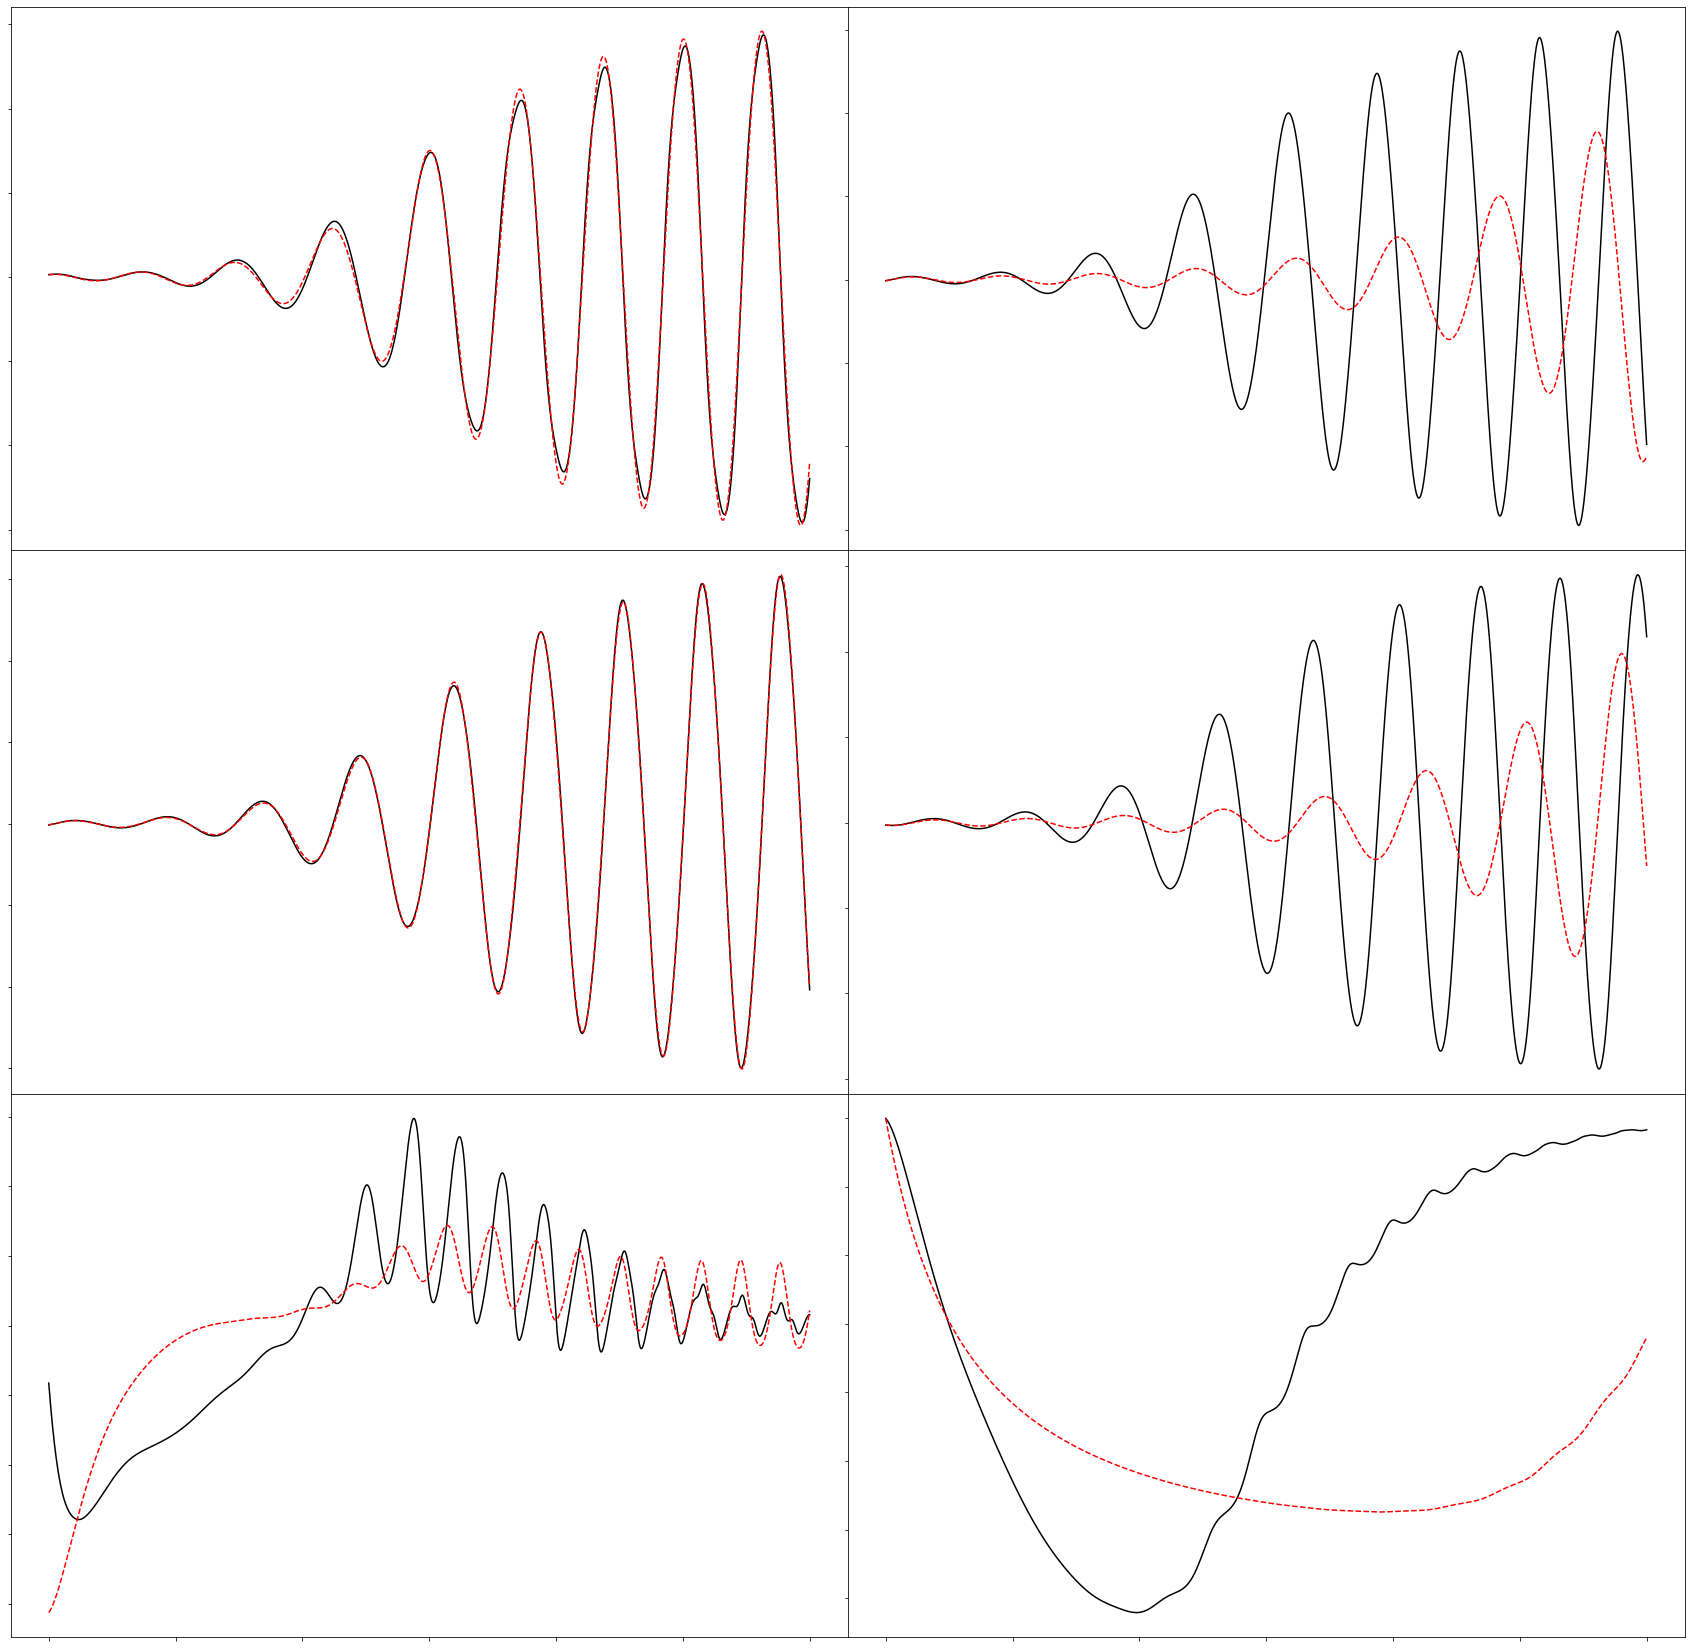

In [13]:
xdot_run1 = model.differentiate(x_run1, t=np.arange(0, 100, 0.02))
xdot_run2 = model.differentiate(x_run2, t=t_run2)

# Simulate the model
xdot_simulate_run1 = model.predict(x_run1)
xdot_simulate_run2 = model.predict(x_run2)

x_simulate_run1 = model.simulate(x_run1[0], t=np.arange(0, 100, 0.02))
x_simulate_run2 = model.simulate(x_run2[0], t=t_run2)

make_fits(r + 1, t_run2, xdot_run2, xdot_simulate_run2, x_train[1], 
          x_simulate_run2, 'cavity_flow_constrained')

# Try Constrained and Trapping models
Note that the constraints are hard on optimizer.coef_full_ but softer on optimizer.coef_ (the model.print() coefficients). Can rectify this by making $\nu \ll 1$ or reducing the threshold. 

In [14]:

# Load training data

dt = 0.02
r = 2
n = r + 1

data_run1 = loadmat("data/PODcoefficients.mat")
x_run1 = np.concatenate(
    (data_run1["alpha"][:5000, :r], data_run1["alphaS"][:5000, 0:1]), axis=1
)
t_run1 = np.arange(0, dt * x_run1.shape[0], dt)

data_run2 = loadmat("data/PODcoefficients_run1.mat")
x_run2 = np.concatenate(
    (data_run2["alpha"][:3000, :r], data_run2["alphaS"][:3000, 0:1]), axis=1
)
t_run2 = np.arange(0, dt * x_run2.shape[0], dt)

x_train = [x_run1, x_run2]
t_train = [t_run1, t_run2]
print(np.shape(x_train[0]))

# Fit the model
constraint_zeros, constraint_matrix = make_constraints_bias(r + 1)
optimizer = ps.ConstrainedSR3(threshold=1e-6,
                              constraint_lhs=constraint_matrix,
                              constraint_rhs=constraint_zeros,
                              constraint_order='feature',
                              tol=1e-8,
                              nu=1,
                              max_iter=500
                             )
# Initialize quadratic SINDy library, with custom ordering to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, 
                                 function_names=library_function_names,
                                 include_bias=True)

model = ps.SINDy(
    optimizer=optimizer, feature_library=sindy_library, feature_names=["x", "y", "z"]
)
model.fit(x_train[0], t_train[0], quiet=True)
model.print(precision=7)
print(model.get_feature_names())

(5000, 3)
x' = -0.3612469 1 + -0.0218034 x + -1.0333312 y + -0.0051295 z + 0.0000135 xy + -0.0003722 xz + -0.0023051 yz + 0.0000139 yy + -0.0000178 zz
y' = -0.0919673 1 + 1.0322857 x + 0.0355777 y + -0.0020789 z + -0.0000139 xy + 0.0022351 xz + -0.0003715 yz + -0.0000135 xx + -0.0000091 zz
z' = -5.3875550 1 + 0.0001534 x + -0.0008381 y + -0.0418801 z + 0.0000700 xy + 0.0000178 xz + 0.0000091 yz + 0.0003722 xx + 0.0003715 yy
['1', 'x', 'y', 'z', 'xy', 'xz', 'yz', 'xx', 'yy', 'zz']


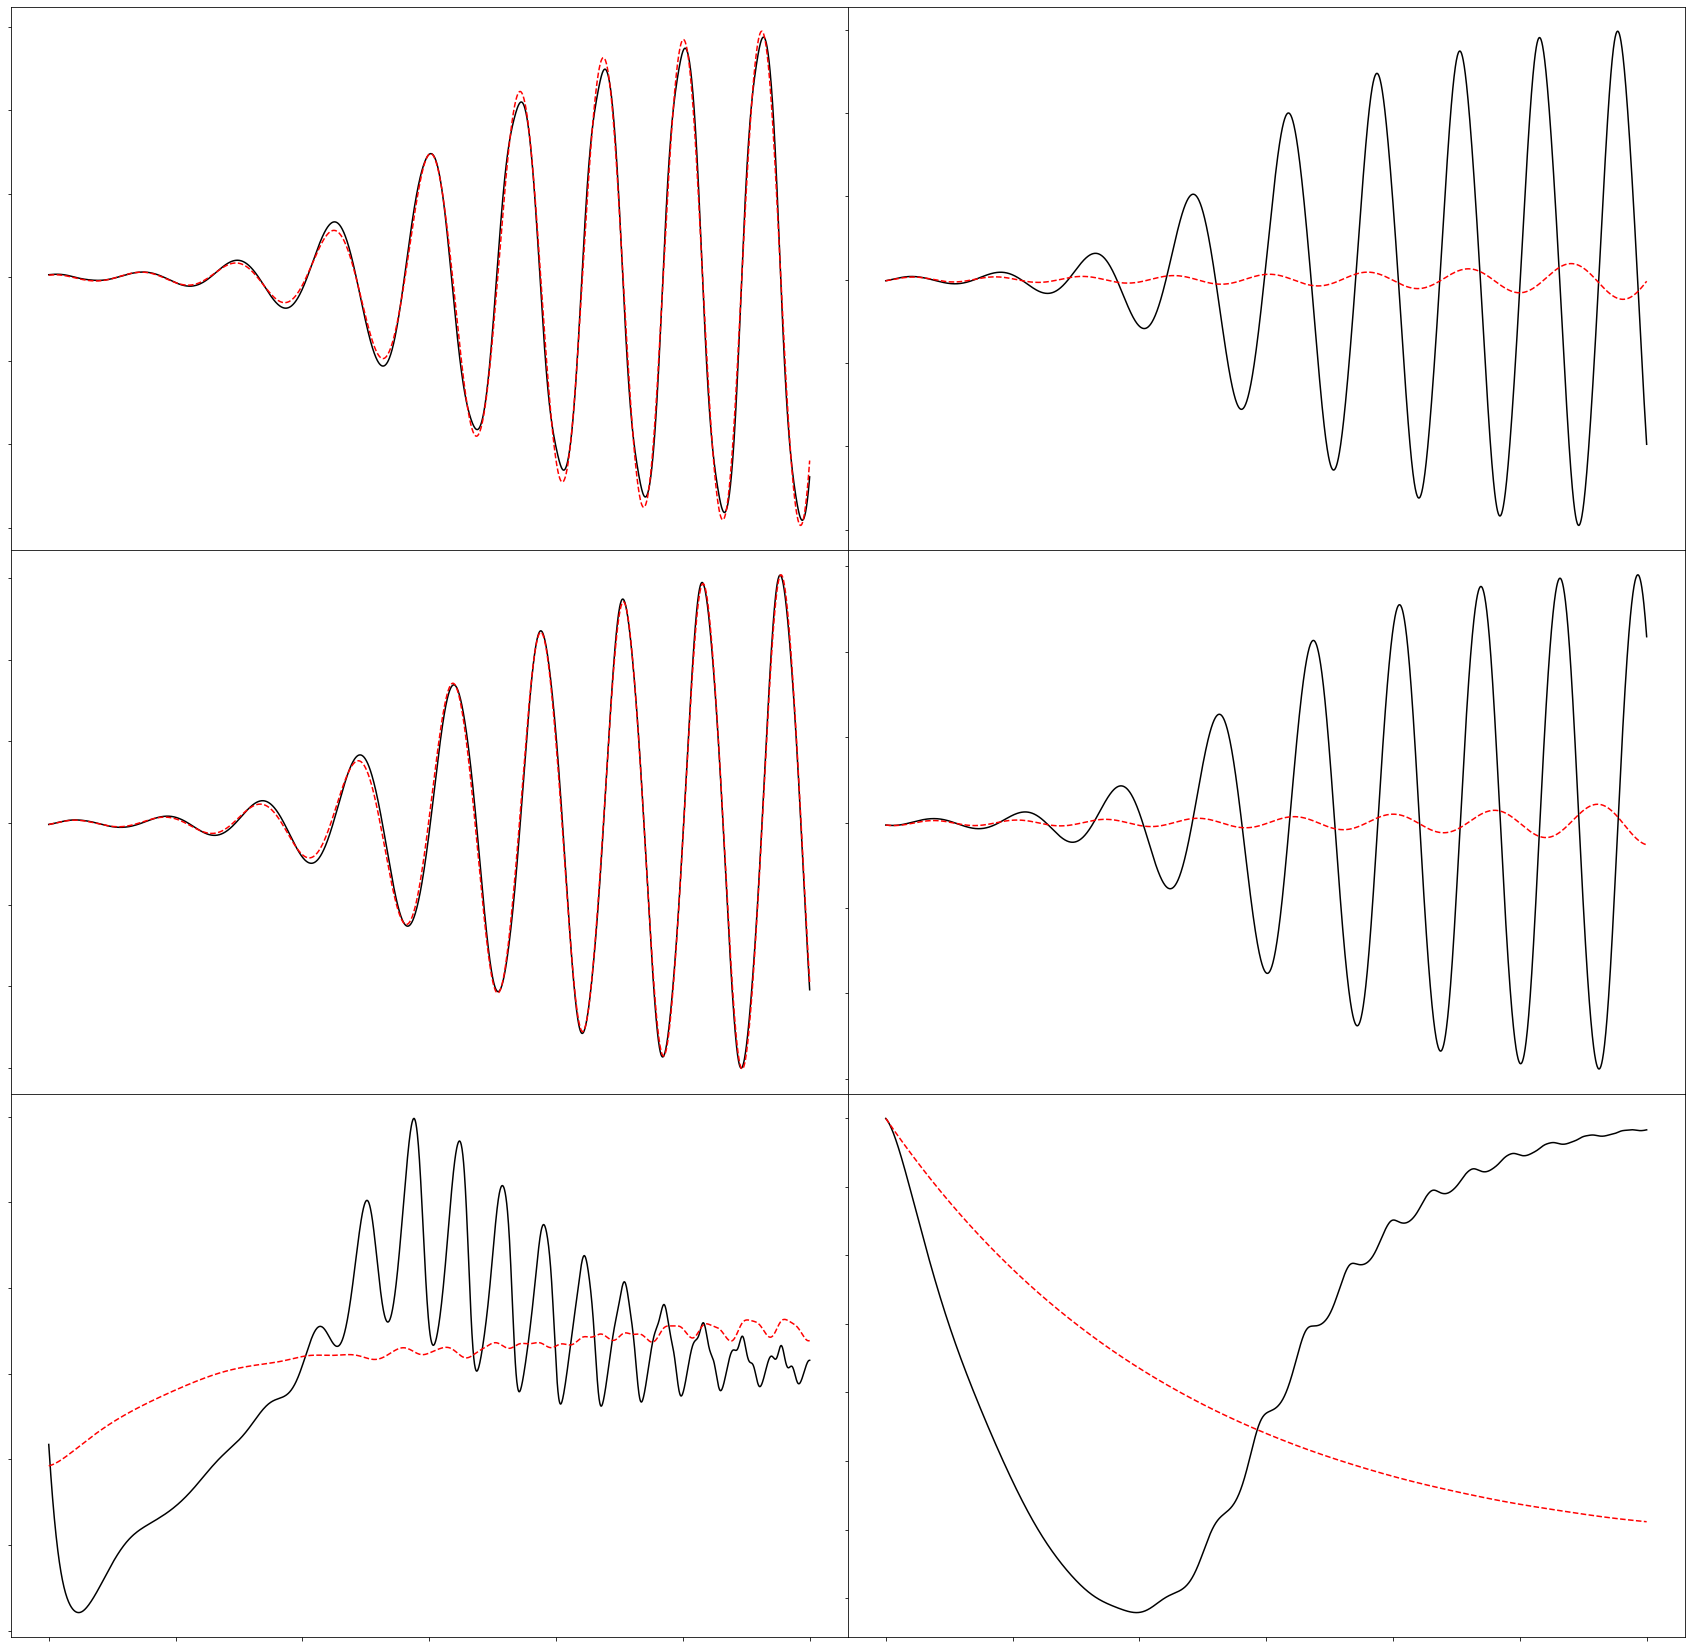

In [15]:
xdot_run1 = model.differentiate(x_run1, t=np.arange(0, 100, 0.02))
xdot_run2 = model.differentiate(x_run2, t=t_run2)

# Simulate the model
xdot_simulate_run1 = model.predict(x_run1)
xdot_simulate_run2 = model.predict(x_run2)

x_simulate_run1 = model.simulate(x_run1[0], t=np.arange(0, 100, 0.02))
x_simulate_run2 = model.simulate(x_run2[0], t=t_run2)

make_fits(r + 1, t_run2, xdot_run2, xdot_simulate_run2, x_train[1], 
          x_simulate_run2, 'cavity_flow_constrained')

In [16]:
# For now, cannot include bias term with trapping
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, 
                                 function_names=library_function_names)

PL_tensor_unsym, PL_tensor, PQ_tensor = make_Ptensor(r + 1)
constraint_zeros, constraint_matrix = make_constraints(r + 1)

eta = 1.0e-8
alpha_m = eta * 5e-2
alpha_A = eta
optimizer = ps.TrappingSR3(threshold=0.0, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, 
                           tol_m=1e-10,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=50000, tol=1e-20,
                           gamma=-0.1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=True
                          )
model = ps.SINDy(
    optimizer=optimizer, feature_library=sindy_library, feature_names=["x", "y", "z"]
)
model.fit(x_train[0], t_train[0], quiet=True)
model.print(precision=7)
print(model.get_feature_names())

 Iteration | Data Error | Stability Error |   L1 Error
           0  2.82618e+05  1.88872e+06  0.00000e+00
        5000  2.68370e+05  1.80579e+06  0.00000e+00
       10000  2.55133e+05  1.72845e+06  0.00000e+00
       15000  2.43118e+05  1.65798e+06  0.00000e+00
       20000  2.32561e+05  1.59585e+06  0.00000e+00
       25000  2.23723e+05  1.54365e+06  0.00000e+00
       30000  2.16890e+05  1.50316e+06  0.00000e+00
       35000  2.12376e+05  1.47631e+06  0.00000e+00
       40000  2.12980e+05  1.46290e+06  0.00000e+00
       45000  2.37927e+05  1.45393e+06  0.00000e+00
x' = -0.0268220 x + -1.0498452 y + -0.0758792 z + 0.0000937 xy + -0.0000456 xz + -0.0023266 yz + -0.0000618 yy + -0.0004812 zz
y' = 1.0133233 x + 0.0116513 y + -0.1033700 z + 0.0000618 xy + 0.0021834 xz + -0.0000955 yz + -0.0000937 xx + -0.0006589 zz
z' = -0.0215561 x + -0.0096441 y + -0.0723680 z + 0.0001432 xy + 0.0004812 xz + 0.0006589 yz + 0.0000456 xx + 0.0000955 yy
['x', 'y', 'z', 'xy', 'xz', 'yz', 'xx', 'yy', 'zz']

In [17]:
# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, PL_tensor_unsym, sindy_opt):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor = sindy_opt.PL
    PQ_tensor = sindy_opt.PQ
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))  # Want these to be negative
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    print(L)
    print(Q)
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    Reff = Rm
    print('d = ', d)
    print('Rm = ', Rm)
    print('Reff = ', Reff)
    
print(np.shape(model.coefficients().T))
check_stability(r + 1, model.coefficients().T, PL_tensor_unsym, optimizer)

(9, 3)
optimal m:  [-0.96869886 -0.84440691 -2.08252515]
As eigvals:  [-0.1272564  -0.00200963  0.04085945]
[[-0.02682202  1.01332332 -0.02155614]
 [-1.04984522  0.01165134 -0.00964409]
 [-0.0758792  -0.10337    -0.07236801]]
[[[-2.65677178e-19  4.68640684e-05 -2.27810601e-05]
  [ 4.68640684e-05 -6.17802940e-05 -1.16330604e-03]
  [-2.27810601e-05 -1.16330604e-03 -4.81204531e-04]]

 [[-9.37281368e-05  3.08901470e-05  1.09171033e-03]
  [ 3.08901470e-05  2.12332631e-18 -4.77262892e-05]
  [ 1.09171033e-03 -4.77262892e-05 -6.58945499e-04]]

 [[ 4.55621201e-05  7.15957080e-05  2.40602266e-04]
  [ 7.15957080e-05  9.54525784e-05  3.29472749e-04]
  [ 2.40602266e-04  3.29472749e-04  1.95156391e-18]]]
d =  [-0.79102113  1.02857109  0.31385609]
Rm =  32.67255284599999
Reff =  32.67255284599999


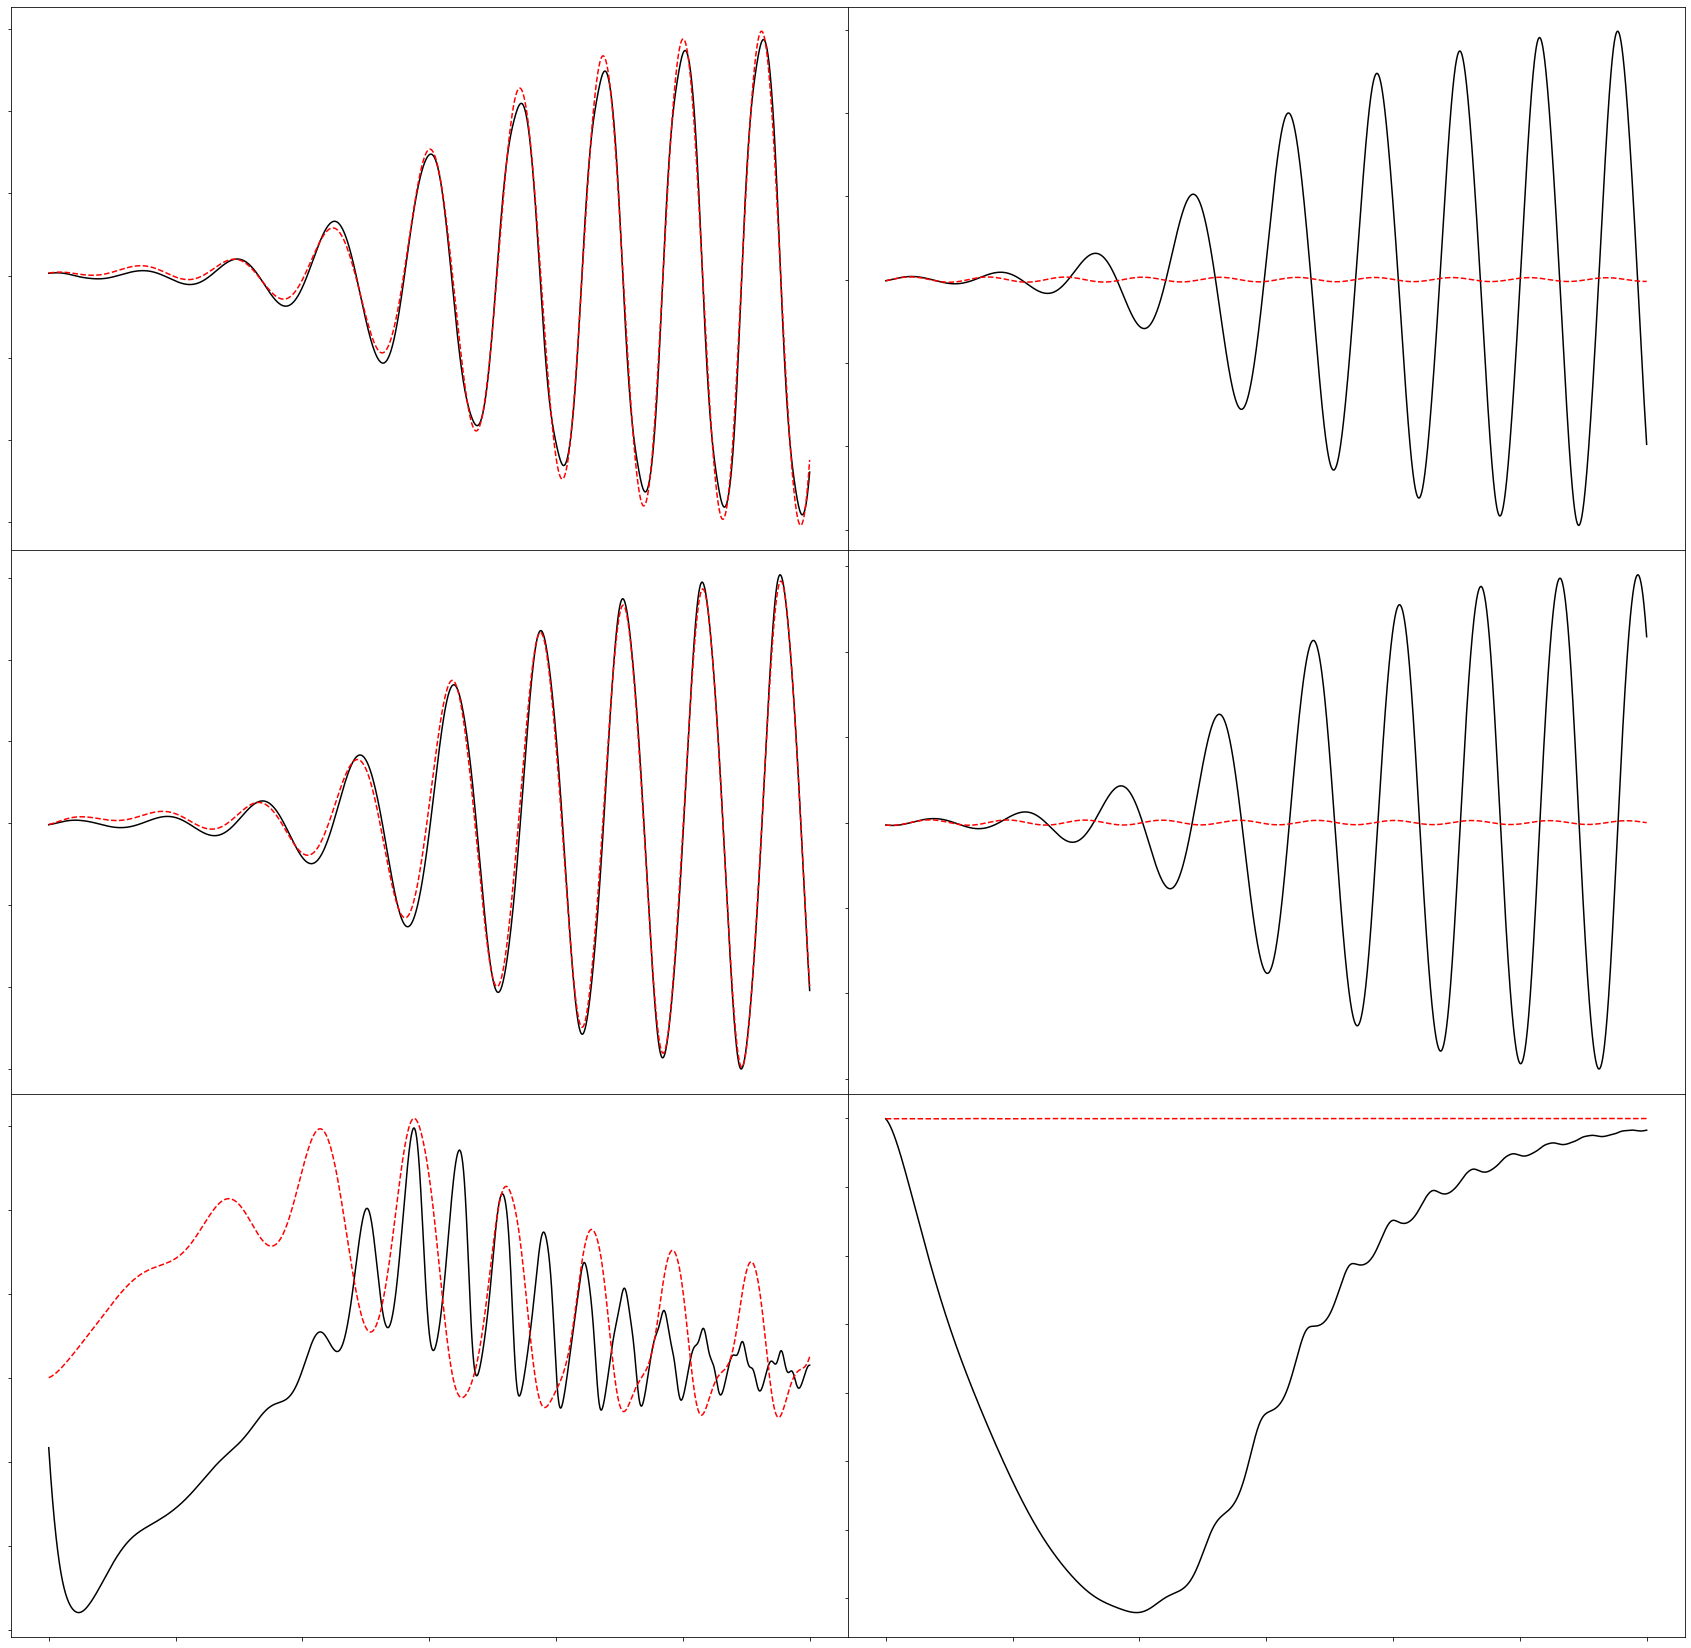

In [18]:
xdot_run1 = model.differentiate(x_run1, t=np.arange(0, 100, 0.02))
xdot_run2 = model.differentiate(x_run2, t=t_run2)

# Simulate the model
xdot_simulate_run1 = model.predict(x_run1)
xdot_simulate_run2 = model.predict(x_run2)

x_simulate_run1 = model.simulate(x_run1[0], t=np.arange(0, 100, 0.02))
x_simulate_run2 = model.simulate(x_run2[0], t=t_run2)

make_fits(r + 1, t_run2, xdot_run2, xdot_simulate_run2, x_train[1], 
          x_simulate_run2, 'cavity_flow_constrained')